- Two parts:
    - 1. make "zeroshot.csv" (HLA(name) - pos_peptide - pep_len - label)
    - 2. build candidate pools for each HLA

1. make "zeroshot.csv"

In [1]:
def get_pos_pep_list(fasta_name):
    pos_pep_file = open(fasta_name,"r")
    line = pos_pep_file.readline()

    pos_pep_list = []
    while line:
        if line.find(">P_Seq") != -1:
            line = pos_pep_file.readline()
            pos_pep_list.append(line.strip("\n"))
        line = pos_pep_file.readline()
    
    return pos_pep_list

In [2]:
from collections import defaultdict

data_path = "/data/lujd/neoag_data/raw_data/"
hla2poe_pep_dict = defaultdict(list)

hla2poe_pep_dict["HLA-G*01:01"] = get_pos_pep_list(data_path + "Pos_G0101.fasta")
hla2poe_pep_dict["HLA-G*01:03"] = get_pos_pep_list(data_path + "Pos_G0103.fasta")
hla2poe_pep_dict["HLA-G*01:04"] = get_pos_pep_list(data_path + "Pos_G0104.fasta")
hla2poe_pep_dict["HLA-E*01:01"] = get_pos_pep_list(data_path + "Pos_E0101.fasta")
hla2poe_pep_dict["HLA-E*01:03"] = get_pos_pep_list(data_path + "Pos_E0103.fasta")

total_num = 0
for hla, seq_list in hla2poe_pep_dict.items():
    print(hla,"\tpositive samples:",len(seq_list))
    total_num += len(seq_list)
print(total_num)

HLA-G*01:01 	positive samples: 2633
HLA-G*01:03 	positive samples: 751
HLA-G*01:04 	positive samples: 812
HLA-E*01:01 	positive samples: 142
HLA-E*01:03 	positive samples: 632
4970


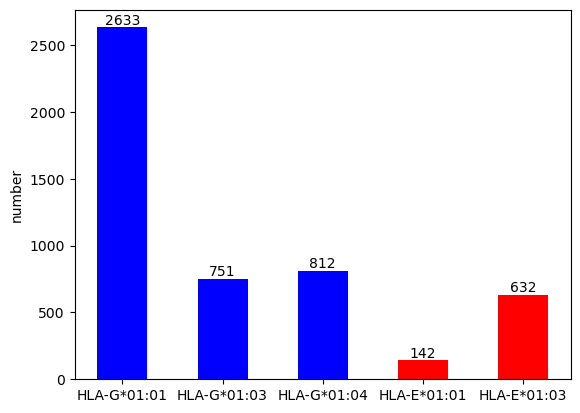

In [4]:
import matplotlib.pyplot as plt

name = ["HLA-G*01:01", "HLA-G*01:03", "HLA-G*01:04", "HLA-E*01:01", "HLA-E*01:03"]
color = ["blue", "blue", "blue", "red", "red"]

number = []
for hla in name:
    number.append(len(hla2poe_pep_dict[hla]))

bar_plot = plt.bar(name, number, color=color, width=0.5, label='value')
plt.bar_label(bar_plot, label_type='edge')
plt.ylabel("number")

plt.show()

In [38]:
print(
    len(set(hla2poe_pep_dict["HLA-G*01:01"])),
    len(set(hla2poe_pep_dict["HLA-G*01:03"])),
    len(set(hla2poe_pep_dict["HLA-G*01:04"])),
    len(set(hla2poe_pep_dict["HLA-E*01:01"])),
    len(set(hla2poe_pep_dict["HLA-E*01:03"]))
)   # no duplicate sequences

2633 751 812 142 632


In [28]:
import pandas as pd

zeroshot_df = pd.DataFrame(columns=["HLA","peptide","length","label"])

HLA_list, pep_list, len_list, label_list = [], [], [], []
for hla, seq_list in hla2poe_pep_dict.items():
    HLA_list += [hla]*len(seq_list)
    pep_list += seq_list
    len_list += [len(seq) for seq in seq_list]
    label_list += [1]*len(seq_list)

zeroshot_df["HLA"] = HLA_list
zeroshot_df["peptide"] = pep_list
zeroshot_df["length"] = len_list
zeroshot_df["label"] = label_list

print(zeroshot_df[2630:2635])
print(len(zeroshot_df))

              HLA        peptide  length  label
2630  HLA-G*01:01     YSVWIGGSIL      10      1
2631  HLA-G*01:01     YVAIQAVLSL      10      1
2632  HLA-G*01:01      YYPNPPLVL       9      1
2633  HLA-G*01:03  AERPPSKPPPVEL      13      1
2634  HLA-G*01:03      AFPGASLYL       9      1


4970

In [30]:
zeroshot_df.to_csv(
    "/data/lujd/neoag_data/main_task/zeroshot_set.csv"
    )

2. build candidate pools for each HLA (only E/G)

(1) negative pool

In [33]:
import numpy as np
from collections import Counter

data_path = "/data/lujd/neoag_data/main_task/"

neg_pep_seg_pools = np.load(
        data_path + "IEDB_negative_segments.npy",       # seg_list
        allow_pickle=True,
        )
print(Counter([len(_) for _ in neg_pep_seg_pools]))

Counter({9: 85607, 10: 59041, 11: 47780, 12: 43885, 13: 38074, 14: 31693, 8: 778})


(2) positive segments of HLA E/G

In [49]:
import pandas as pd

zeroshot_data = pd.read_csv(
            data_path + 'zeroshot_set.csv', 
            index_col=0
            )[['peptide', 'HLA', 'length', 'label']]

print(
    len(zeroshot_data),
    len(zeroshot_data[zeroshot_data.label==1]),
    zeroshot_data.peptide.nunique(),
)

4970 4970 3613


In [50]:
print(
    len(set(neg_pep_seg_pools).intersection(set(zeroshot_data.peptide))),
    len(set(zeroshot_data.peptide)),
    len(set(neg_pep_seg_pools)),
    )

39 3613 306858


In [56]:
lengths = [8, 9, 10, 11, 12, 13, 14, 15]
total_num = 0
for length in lengths:
    print(length, "\tnumber:",len(zeroshot_data[zeroshot_data.length == length]))
    total_num += len(zeroshot_data[zeroshot_data.length==length])
print(total_num)

for hla in zeroshot_data.HLA.unique():
    print(hla, Counter(zeroshot_data[zeroshot_data.HLA==hla].length))

8 	number: 420
9 	number: 3765
10 	number: 454
11 	number: 185
12 	number: 63
13 	number: 39
14 	number: 19
15 	number: 25
4970
HLA-G*01:01 Counter({9: 1974, 8: 292, 10: 240, 11: 96, 12: 16, 13: 12, 14: 2, 15: 1})
HLA-G*01:03 Counter({9: 609, 10: 49, 8: 42, 11: 20, 12: 14, 13: 7, 15: 6, 14: 4})
HLA-G*01:04 Counter({9: 634, 10: 74, 8: 57, 11: 21, 12: 14, 13: 6, 14: 4, 15: 2})
HLA-E*01:01 Counter({9: 128, 11: 4, 15: 4, 8: 3, 13: 2, 12: 1})
HLA-E*01:03 Counter({9: 420, 10: 91, 11: 44, 8: 26, 12: 18, 15: 12, 13: 12, 14: 9})


In [57]:
from collections import defaultdict

lengths = [8, 9, 10, 11, 12, 13, 14, 15]
HLA_list = list(set(zeroshot_data['HLA']))
print(len(HLA_list))
    
pos_pep_segs_dict = defaultdict(set)
for HLA in sorted(HLA_list):
    cur_HLA_zeroshot_data = zeroshot_data[zeroshot_data['HLA'] == HLA]
    curr_pep_set = set(cur_HLA_zeroshot_data['peptide'].to_list())
    
    for length in lengths:
        for pep in curr_pep_set:
            if len(pep) < length:
                continue
            startpos, stoppos = 0, length
            while stoppos < len(pep) + 1:
                pos_pep_segs_dict[HLA].add(pep[startpos: stoppos])
                startpos += 1
                stoppos += 1
    print("HLA: {}\tpositive samples: {}\tsegment num: {}".format(HLA, len(curr_pep_set), len(pos_pep_segs_dict[HLA])))  

5
HLA: HLA-E*01:01	positive samples: 142	segment num: 606
HLA: HLA-E*01:03	positive samples: 632	segment num: 3273
HLA: HLA-G*01:01	positive samples: 2633	segment num: 8828
HLA: HLA-G*01:03	positive samples: 751	segment num: 2869
HLA: HLA-G*01:04	positive samples: 812	segment num: 2958


In [58]:
# validation
for hla, pep_set in pos_pep_segs_dict.items():
    print(hla, Counter([len(_) for _ in pep_set]))

    for kk, vv in Counter([len(_) for _ in pep_set]).items():
        assert kk in set(list(range(8,16)))

    for pep in set(zeroshot_data[zeroshot_data['HLA']==hla]['peptide'].to_list()):
        assert pep in pep_set
        for length in range(8, 16):
            startpos, stoppos = 0, length
            while stoppos < len(pep) + 1:
                assert pep[startpos: stoppos] in pep_set
                startpos += 1
                stoppos += 1

HLA-E*01:01 Counter({8: 308, 9: 179, 10: 41, 11: 31, 12: 21, 13: 14, 14: 8, 15: 4})
HLA-E*01:03 Counter({8: 1536, 9: 952, 10: 374, 11: 197, 12: 108, 13: 62, 14: 32, 15: 12})
HLA-G*01:01 Counter({8: 5301, 9: 2794, 10: 509, 11: 161, 12: 42, 13: 17, 14: 3, 15: 1})
HLA-G*01:03 Counter({8: 1593, 9: 877, 10: 190, 11: 101, 12: 57, 13: 30, 14: 15, 15: 6})
HLA-G*01:04 Counter({8: 1693, 9: 923, 10: 193, 11: 82, 12: 40, 13: 18, 14: 7, 15: 2})


(3) remove positive segments from the negative pool

In [64]:
import numpy as np 

zeroshot_candidate_pool = defaultdict(set)
print(len(set(neg_pep_seg_pools)))

for HLA in zeroshot_data.HLA.unique():
    zeroshot_candidate_pool[HLA] = set(neg_pep_seg_pools) - pos_pep_segs_dict[HLA]
for k, v in zeroshot_candidate_pool.items():
    print(k, len(v))

306858
HLA-G*01:01 306847
HLA-G*01:03 306852
HLA-G*01:04 306852
HLA-E*01:01 306841
HLA-E*01:03 306823


In [ ]:
np.save(data_path+"zeroshot_allele2positive_segs.npy", pos_pep_segs_dict)
np.save(data_path+"zeroshot_allele2candidate_pools.npy", zeroshot_candidate_pool)